In [31]:
import sklearn
import pickle 
import tsa_utils
import pandas as pd 
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA
import cv2
import skimage

# Local Setup

In [52]:
DATA_PATH="../tsa_data/images/"
CHECKPOINT_PATH="../tsa_data/multi-class8"
MODEL_ID="pca10"
tensors_to_log =  {"probabilities": "prob_tensor",
                    "actual":"labels"}
image_df = pd.read_csv(DATA_PATH + '/stage1_labels.csv')
image_df['zone'] = image_df['Id'].str.split("_Zone", expand=True)[1].str.strip()
image_df['id'] = image_df['Id'].str.split("_", expand=True)[0].str.strip()
ids = image_df["id"].unique()

(10560, 512)


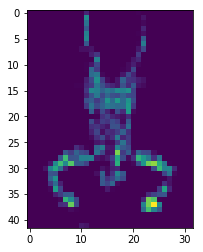

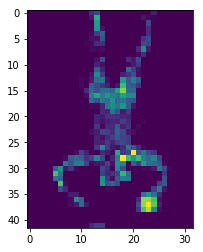

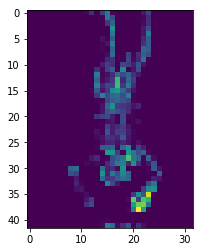

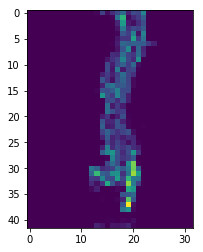

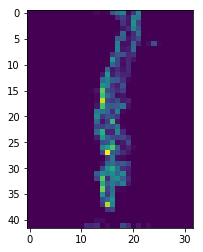

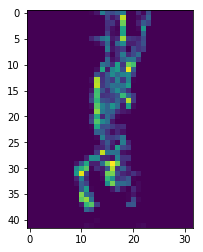

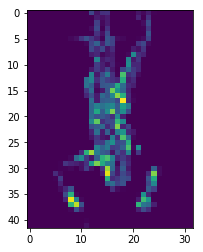

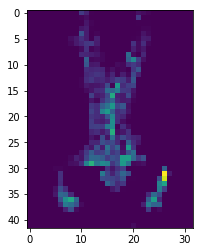

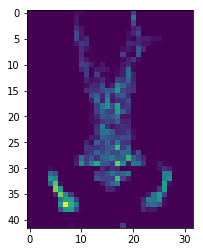

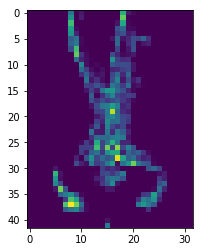

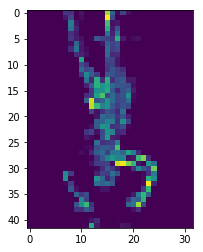

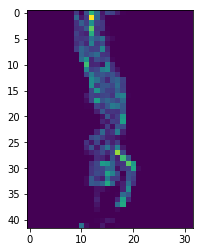

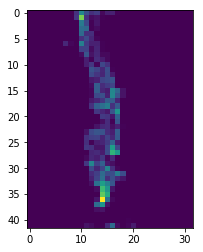

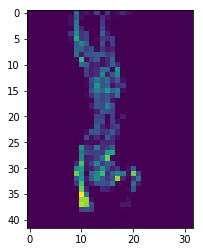

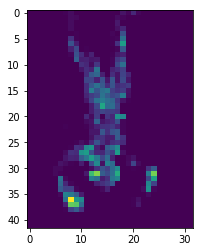

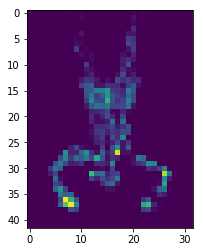

In [53]:


data = tsa_utils.read_data(DATA_PATH + "/678074e9d3aa9ab9fec3f348002f5ca0.aps").reshape(16 * 660, 512, order="A")
data *= 255/data.max() 
print(data.shape)
data = data.astype(np.uint8)
data = cv2.adaptiveThreshold(data,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,5)
data = data.astype(np.float64)

transformed = pca_model.transform([data.flatten()])
reverse_transformed = pca_model.inverse_transform(transformed) 
reverse_transformed = reverse_transformed[0]

reverse_transformed *= 255/reverse_transformed.max() 
reverse_transformed = reverse_transformed.astype(np.uint8)
reverse_transformed = cv2.adaptiveThreshold(reverse_transformed,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,91,5)
reverse_transformed = reverse_transformed.astype(np.float64)
reverse_transformed *= 255.0/reverse_transformed.max() 

reverse_transformed = reverse_transformed.flatten().astype(np.float64)
binary_transformed = reverse_transformed.copy()
binary_transformed[reverse_transformed > 220] = 0
binary_transformed[reverse_transformed < 220] = 1
data = data.flatten()
binary_data = data.copy()
binary_data[data > 1] = 0
binary_data[data < 1] = 1


diff = binary_data.flatten() - binary_transformed
diff = diff.reshape(-1,512)
diff[diff<=0] = 0
diff[diff>0] = 1

diff = diff.reshape(16,-1,512)
diff = skimage.measure.block_reduce(diff, (1,16,16), np.mean)
for i in range (0,16):
    #plt.imshow(diff[i*41:(i+1)*41])
    plt.imshow(diff[i])
    plt.show()

# Floyd Setup

In [46]:
DATA_PATH="/data_volume/"
CHECKPOINT_PATH="/output/multi-class8"
MODEL_ID="pca10"
tensors_to_log =  {"probabilities": "prob_tensor",
                    "actual":"labels"}


pca_model = pickle.load(open("/output/pca_model.p","rb"))
test_ids = pickle.load(open("/output/test_ids.p","rb"))
train_ids = pickle.load(open("/output/train_ids.p","rb"))

image_df = pd.read_csv(DATA_PATH + '/stage1_labels.csv')
image_df['zone'] = image_df['Id'].str.split("_Zone", expand=True)[1].str.strip()
image_df['id'] = image_df['Id'].str.split("_", expand=True)[0].str.strip()
ids = image_df["id"].unique()
test_df = image_df[image_df["id"].isin(test_ids)]
train_df = image_df[image_df["id"].isin(train_ids)]

FileNotFoundError: [Errno 2] No such file or directory: '/output/test_ids.p'

# Build Data 

In [54]:
pca_model = IncrementalPCA(n_components=70)
train_ids, test_ids, y_train, y_test = sklearn.model_selection.train_test_split(ids, ids, test_size=.1)
data_buffer=[]
for train_id in train_ids[:300]:
    data = tsa_utils.load_thresholded_image(DATA_PATH + "/" + train_id + ".aps").flatten()
    data_buffer.append(data)
    if len(data_buffer) > 70:
        print("FIT BATCH")
        pca_model.partial_fit(data_buffer)
        data_buffer =[]
pca_model.partial_fit(data_buffer)
print("FIT PCA MODEL")
pickle.dump(train_ids, open(CHECKPOINT_PATH + "train_ids.p","wb+"))
pickle.dump(test_ids, open(CHECKPOINT_PATH + "test_ids.p","wb+"))
pickle.dump(pca_model, open(CHECKPOINT_PATH + "pca_model.p","wb+"))

FIT BATCH
FIT BATCH
FIT BATCH
FIT BATCH
FIT PCA MODEL


OSError: [Errno 22] Invalid argument

In [58]:
train_df = image_df[image_df["id"].isin(train_ids)]
test_df = image_df[image_df["id"].isin(test_ids)]

In [4]:
classifiers = []    
classifier_types=[sklearn.svm.SVC(),LogisticRegression()]
threshold_xs=[5,11,20,50,90,200]
threshold_ys=[1,3,5,10,20]
pool_sizes=[1,2,5,10,15]
threshold_thresholds=[200,210,220,230,240]
for classifier_type in classifier_types:
    print(classifier_type)
    for threshold_x in threshold_xs:
        print(threshold_x)
        for threshold_y in threshold_ys:
            print(threshold_y)
            for threshold_threshold in threshold_thresholds:
                print(threshold_threshold)
                for pool_size in pool_sizes:
                    print(pool_size)
                    pca_model = IncrementalPCA(n_components=70)
                    train_ids, test_ids, y_train, y_test = sklearn.model_selection.train_test_split(ids, ids, test_size=.1)
                    data_buffer=[]
                    for train_id in train_ids[:300]:
                        data = tsa_utils.load_thresholded_image(DATA_PATH + "/" + train_id + ".aps",x=threshold_x,y=threshold_y).flatten()
                        data_buffer.append(data)
                        if len(data_buffer) > 70:
                            print("FIT BATCH")
                            pca_model.partial_fit(data_buffer)
                            data_buffer =[]
                    pca_model.partial_fit(data_buffer)
                    print("FIT PCA MODEL")
                    pickle.dump(train_ids, open("/output/train_ids.p","wb+"))
                    pickle.dump(test_ids, open("/output/test_ids.p","wb+"))
                    pickle.dump(pca_model, open("/output/pca_model.p","wb+"))

                    for zone in range(1,5):
                        train_data = []
                        test_data = []
                        iterator = tsa_utils.ResidueIterator(train_ids, DATA_PATH, pca_model, repeating=False,x=threshold_x,y=threshold_y, pool_size=pool_size, threshold=threshold_threshold)
                        for image_id in train_ids:
                            train_data.append(iterator.__next__())
                        train_images = np.array(train_data).reshape([1032,-1])
                        iterator = tsa_utils.ResidueIterator(test_ids, DATA_PATH, pca_model, repeating=False,x=threshold_x,y=threshold_y, pool_size=pool_size, threshold=threshold_threshold)
                        for image_id in test_ids:
                            test_data.append(iterator.__next__())
                        test_images = np.array(test_data).reshape([115,-1])
                        classifier = classifier_type
                        train_labels = train_df[train_df["zone"]==str(zone)]["Probability"]
                        test_labels = test_df[test_df["zone"]==str(zone)]["Probability"]
                        np.save(open(CHECKPOINT_PATH + str(zone)+"trainimages.p","wb+"), train_images)
                        np.save(open(CHECKPOINT_PATH + str(zone)+"testimages.p","wb+"), test_images)
                        classifier.fit(all_images, train_labels)
                        classifiers.append(classifier)
                        y_pred = classifier.predict(test_images)
                        print(sklearn.metrics.f1_score(test_labels, y_pred))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
5
1
200
1
FIT BATCH
FIT BATCH
FIT BATCH
FIT BATCH
FIT PCA MODEL


FileNotFoundError: [Errno 2] No such file or directory: '/output/train_ids.p'

In [60]:
for zone in range(1,5):
    train_data = []
    test_data = []
    iterator = tsa_utils.ResidueIterator(train_ids, DATA_PATH, pca_model, repeating=False,x=threshold_x,y=threshold_y, pool_size=pool_size, threshold=threshold_threshold)
    for image_id in train_ids:
        train_data.append(iterator.__next__())
    train_images = np.array(train_data).reshape([1032,-1])
    iterator = tsa_utils.ResidueIterator(test_ids, DATA_PATH, pca_model, repeating=False,x=threshold_x,y=threshold_y, pool_size=pool_size, threshold=threshold_threshold)
    for image_id in test_ids:
        test_data.append(iterator.__next__())
    test_images = np.array(test_data).reshape([115,-1])
    classifier = classifier_type
    train_labels = train_df[train_df["zone"]==str(zone)]["Probability"]
    test_labels = test_df[test_df["zone"]==str(zone)]["Probability"]
    np.save(open(CHECKPOINT_PATH + str(zone)+"trainimages.p","wb+"), train_images)
    np.save(open(CHECKPOINT_PATH + str(zone)+"testimages.p","wb+"), test_images)
    classifier.fit(all_images, train_labels)
    classifiers.append(classifier)
    y_pred = classifier.predict(test_images)
    print(sklearn.metrics.f1_score(test_labels, y_pred))

NameError: name 'all_images' is not defined

# Load Data Instead

In [59]:
classifiers = []    

for zone in range(1,5):
    #classifier = LogisticRegression()
    classifier = sklearn.svm.SVC()
    train_labels = train_df[train_df["zone"]==str(zone)]["Probability"]
    test_labels = test_df[test_df["zone"]==str(zone)]["Probability"]
    test_images = np.load(open(CHECKPOINT_PATH + str(zone)+"testimages.p","rb+"))
    train_images = np.load(open(CHECKPOINT_PATH + str(zone)+"trainimages.p","rb+"))
    classifier.fit(train_images, train_labels)
    classifiers.append(classifier)
    y_pred = classifier.predict(test_images)
    print(sklearn.metrics.f1_score(test_labels, y_pred))

FileNotFoundError: [Errno 2] No such file or directory: '../tsa_data/multi-class81testimages.p'

# Build PCA Model

In [48]:
pca_model = IncrementalPCA(n_components=70)
train_ids, test_ids, y_train, y_test = sklearn.model_selection.train_test_split(ids, ids, test_size=.1)
data_buffer=[]
for train_id in train_ids:
    data = tsa_utils.load_thresholded_image(DATA_PATH + "/" + train_id + ".aps").flatten()
    data_buffer.append(data)
    if len(data_buffer) > 70:
        pca_model.partial_fit(data_buffer)
        data_buffer =[]
pca_model.partial_fit(data_buffer)
pickle.dump(train_ids, open("/output/train_ids.p","wb+"))
pickle.dump(test_ids, open("/output/test_ids.p","wb+"))
pickle.dump(pca_model, open("/output/pca_model.p","wb+"))

FileNotFoundError: [Errno 2] No such file or directory: '/data_volume/8a3a0461a76394d6d2ae82cc34cb11c5.aps'

# Predict

In [43]:
predict_image_df = pd.read_csv(DATA_PATH + 'stage1_sample_submission.csv')
predict_image_df['zone'] = predict_image_df['Id'].str.split("_", expand=True)[1].str.strip()
predict_image_df['id'] = predict_image_df['Id'].str.split("_", expand=True)[0].str.strip()

predict_ids = predict_image_df["id"].unique()
predict_ids.sort()

FileNotFoundError: File b'./images/stage1_sample_submission.csv' does not exist

In [44]:
predict_data = []
pca_model = pickle.load(open("../tsa_data/pca_models/medium_safe_pca.p","rb"))
iterator = tsa_utils.ResidueIterator(predict_ids, DATA_PATH, pca_model, repeating=False)
for image_id in predict_ids:
    predict_data.append(iterator.__next__())

/home/cody/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator IncrementalPCA from version 0.18.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [45]:
predict_images = np.array(predict_data).reshape([len(predict_ids),-1])

In [46]:
csv_file = open(CHECKPOINT_PATH + "/submission.csv", "w+")
csv_file.write("Id,Probability\n")
for zone in range(1,18):
    classifier = classifiers[zone-1]
    for i, prediction in enumerate(classifier.predict_proba(predict_images)):
        csv_file.write(str(predict_ids[i]) + "_Zone" + str(zone) + "," + str(prediction[1]) + "\n")
csv_file.close()

1


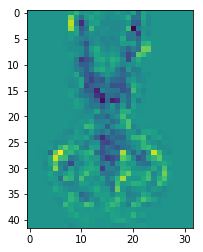

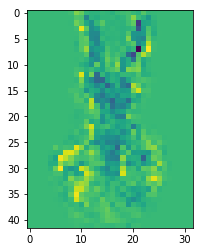

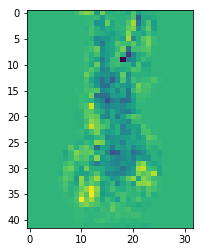

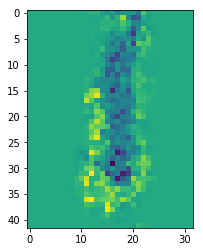

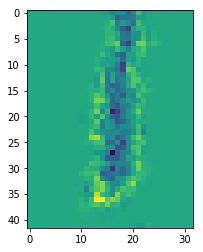

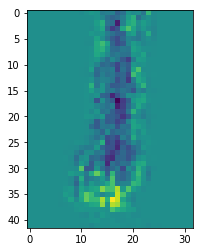

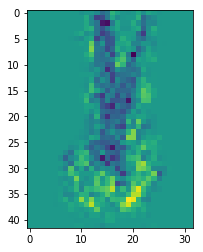

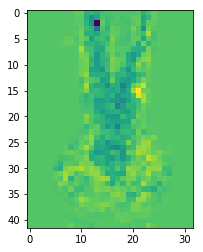

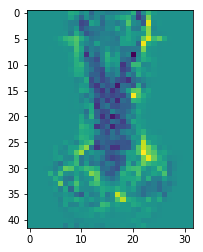

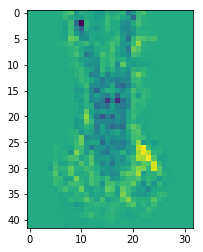

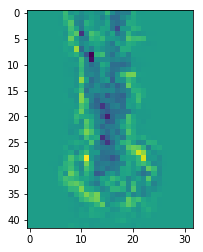

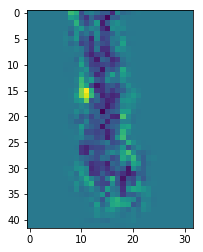

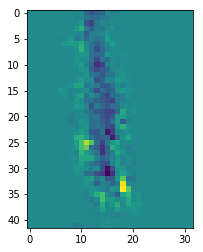

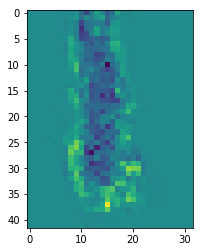

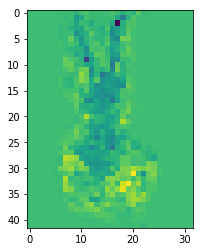

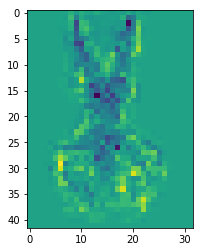

2


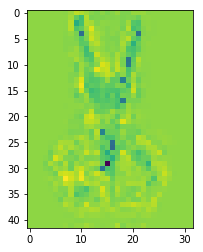

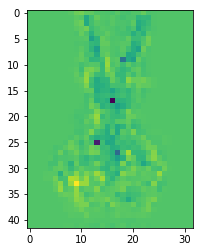

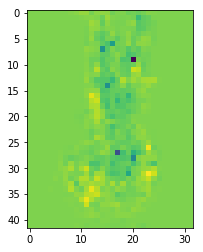

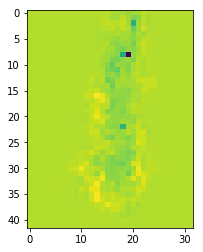

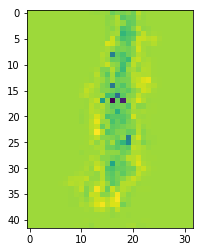

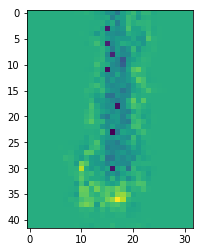

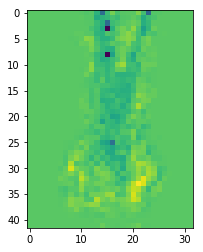

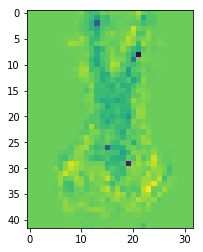

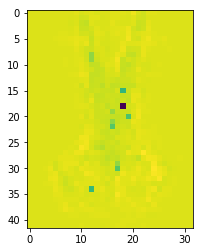

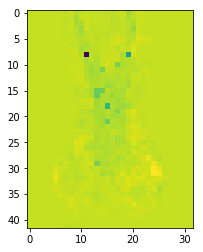

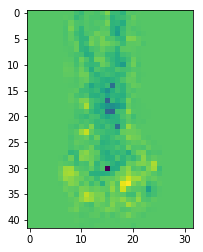

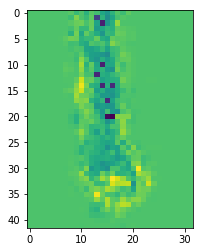

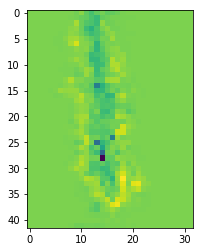

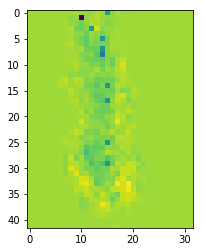

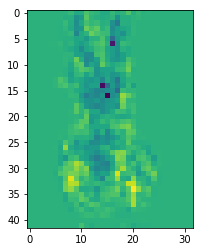

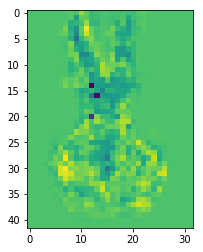

3


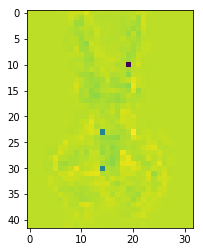

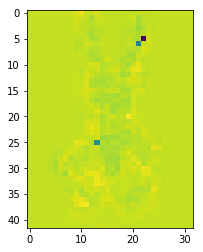

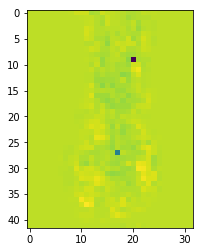

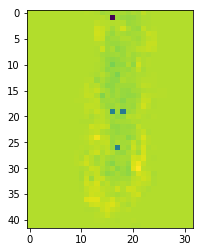

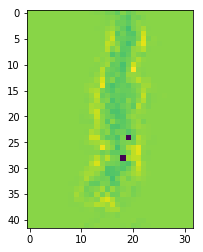

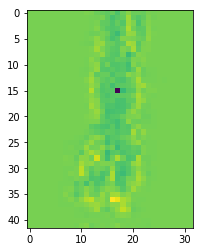

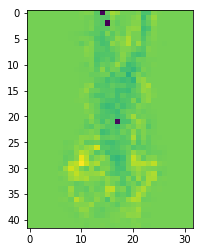

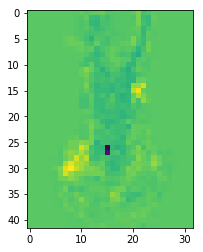

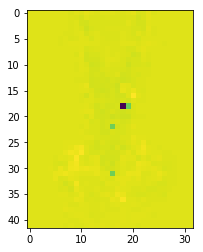

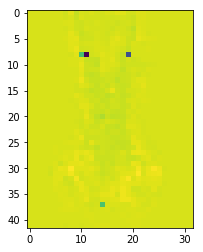

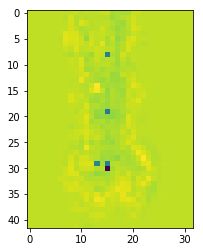

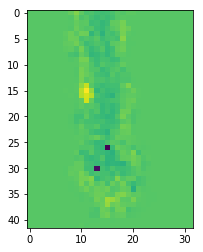

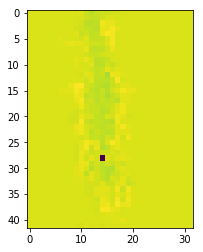

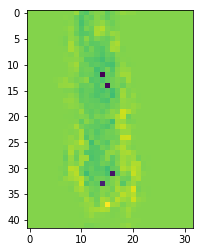

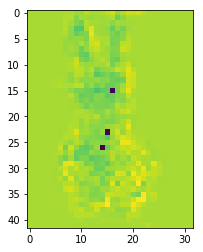

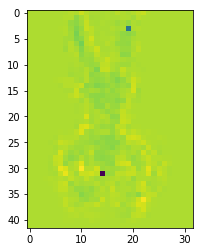

4


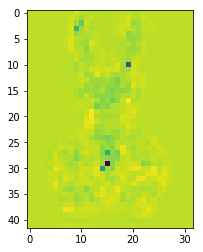

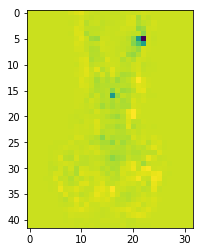

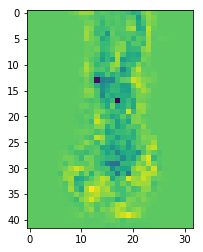

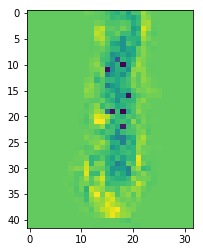

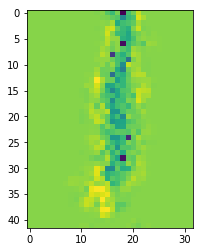

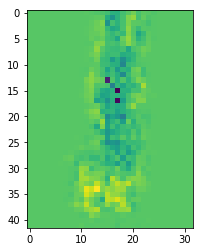

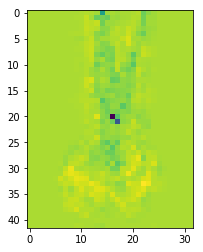

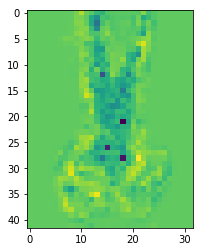

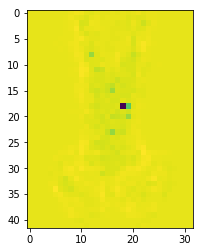

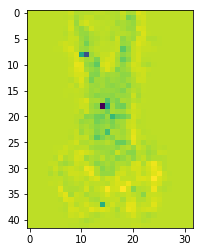

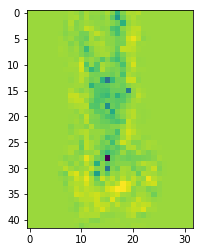

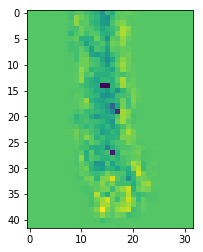

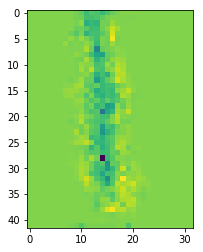

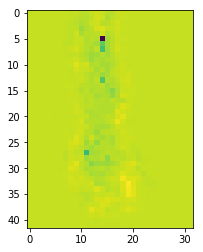

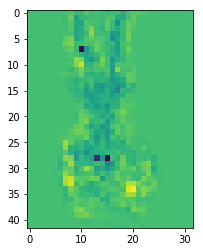

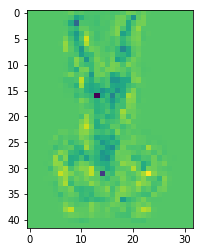

5


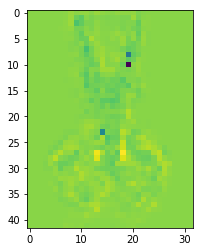

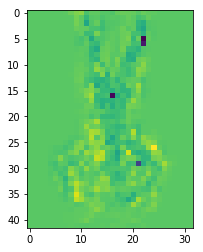

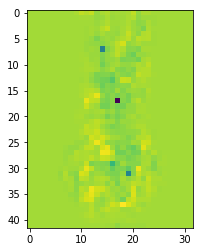

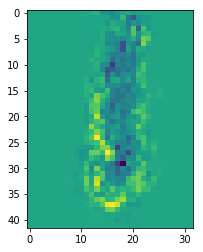

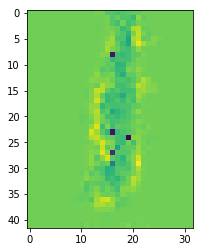

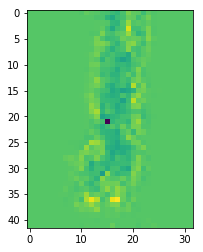

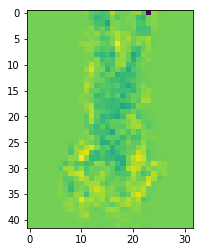

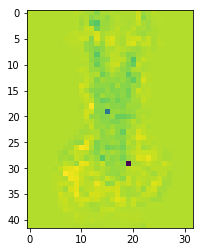

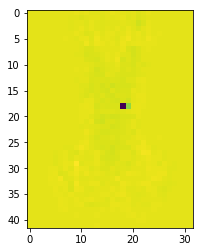

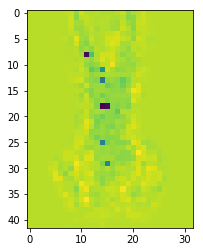

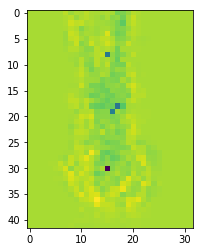

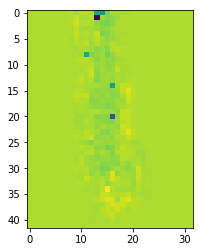

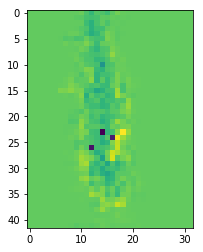

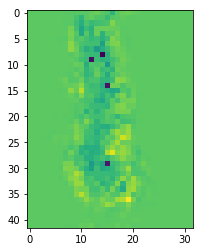

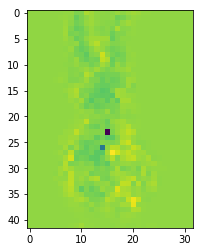

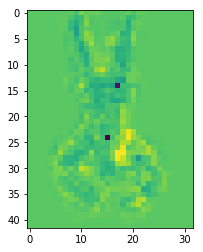

6


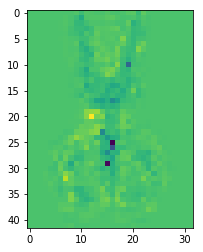

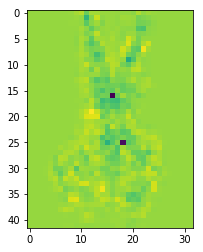

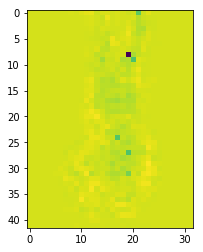

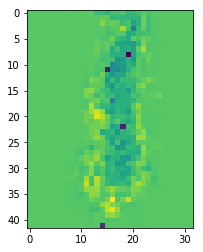

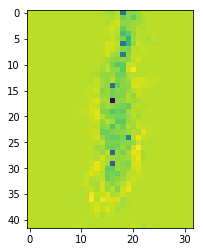

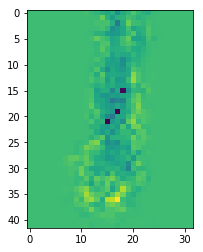

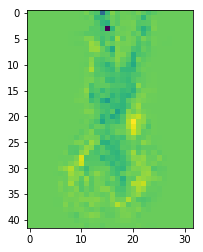

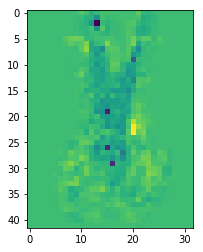

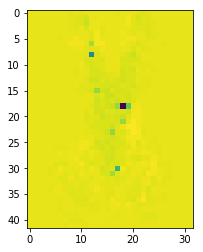

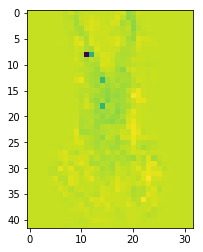

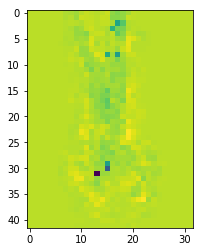

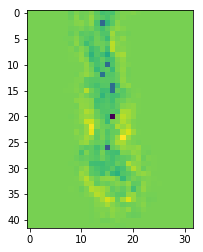

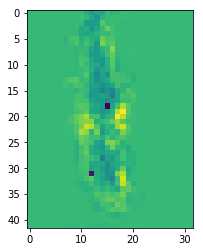

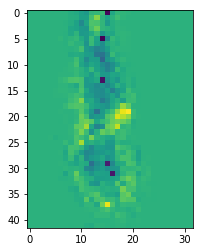

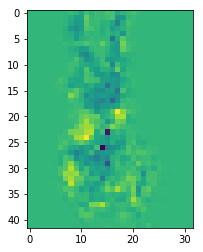

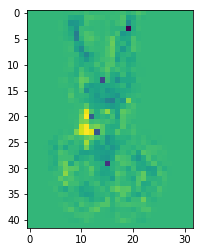

7


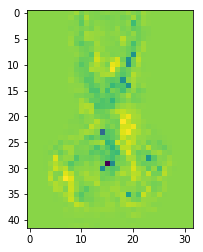

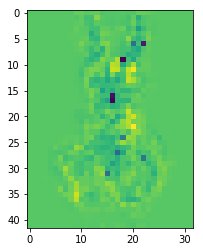

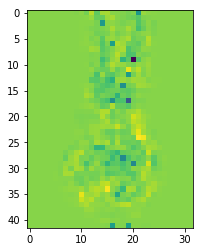

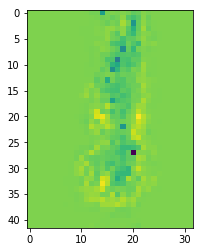

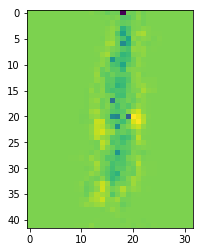

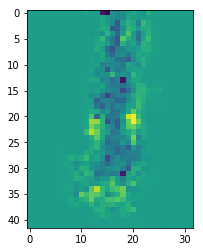

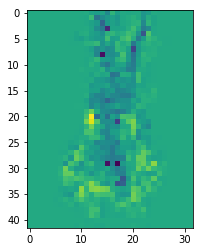

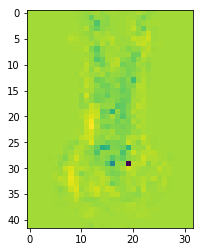

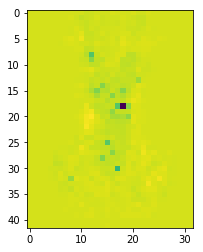

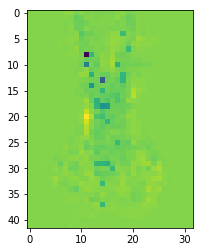

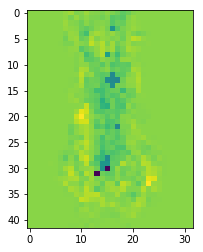

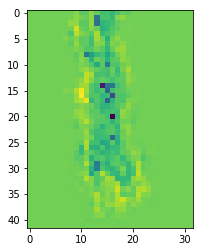

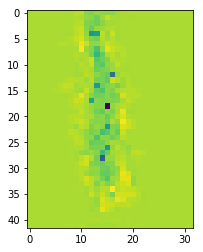

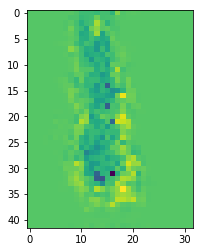

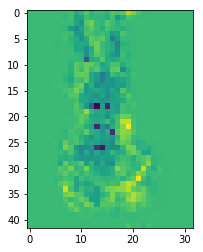

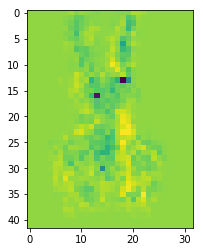

8


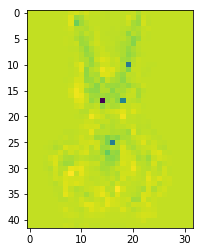

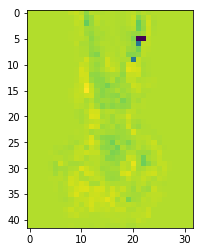

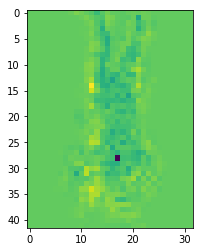

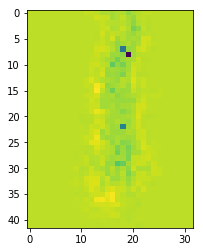

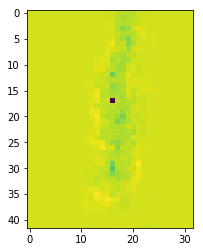

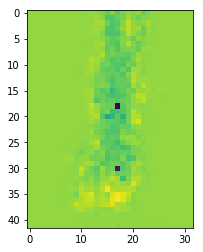

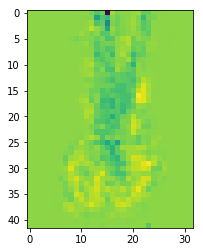

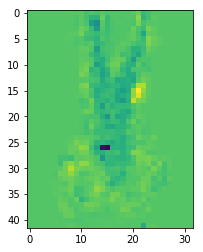

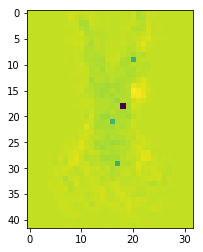

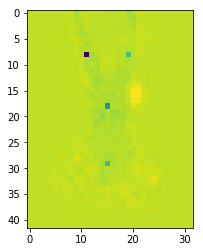

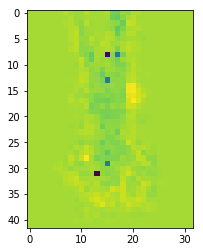

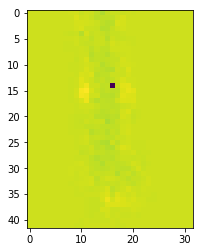

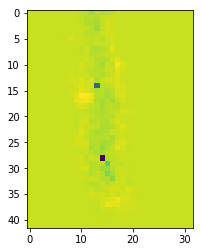

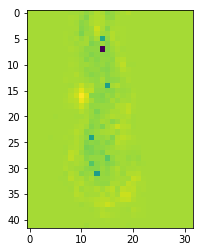

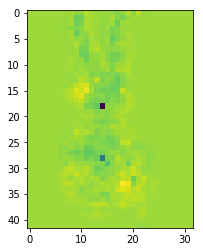

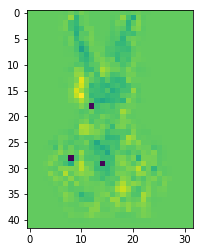

9


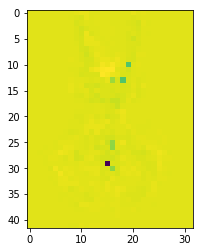

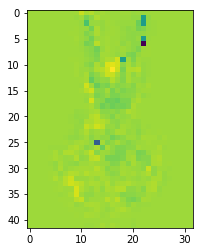

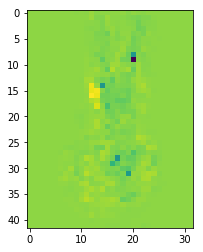

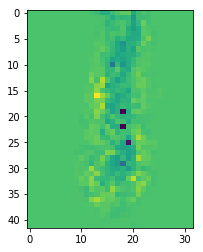

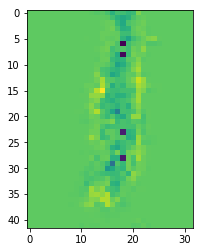

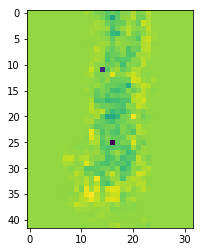

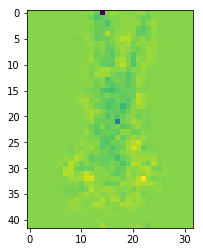

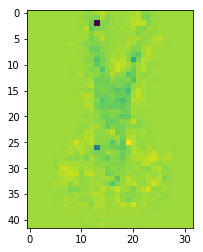

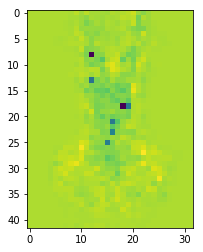

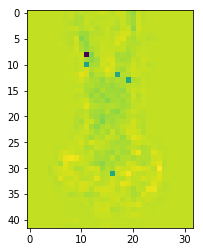

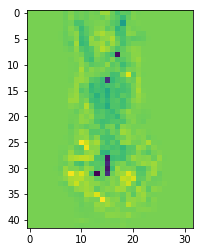

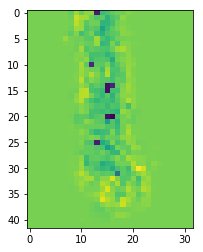

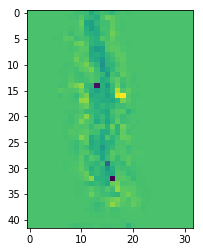

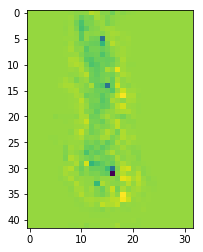

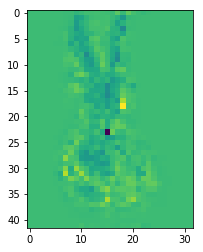

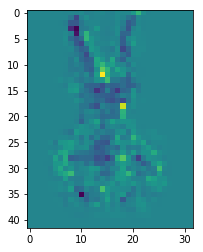

10


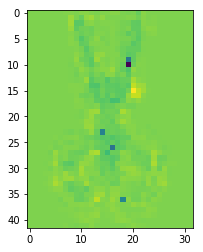

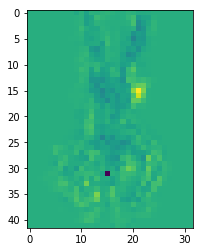

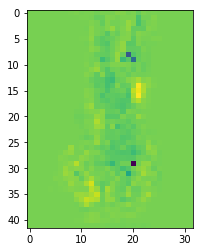

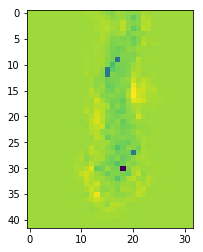

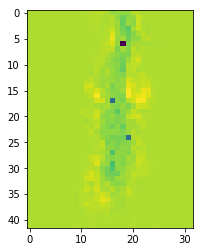

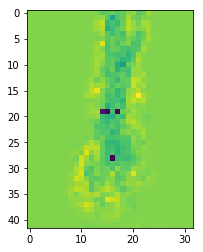

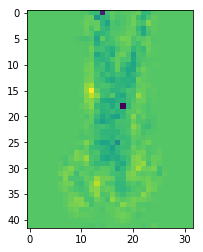

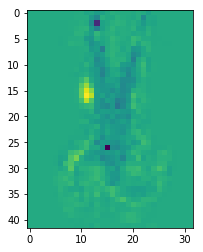

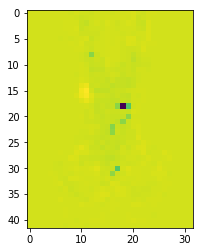

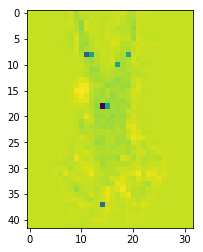

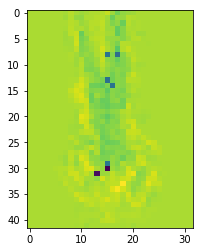

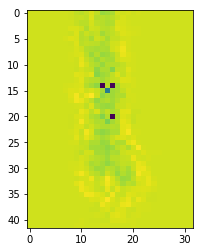

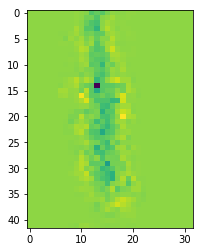

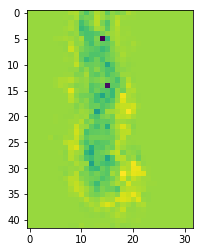

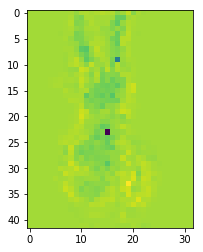

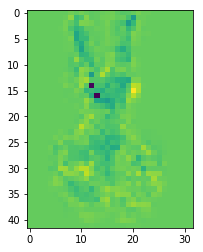

11


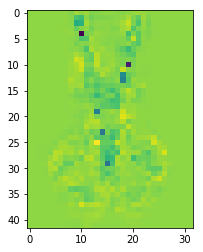

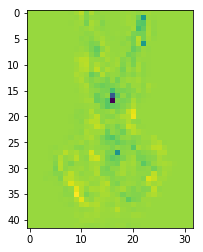

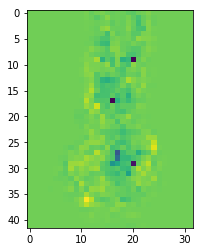

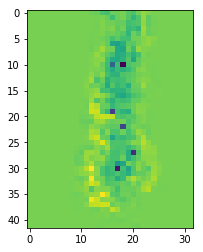

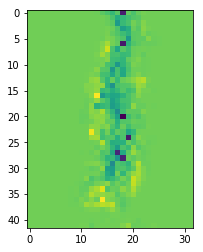

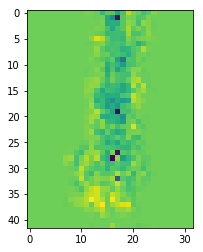

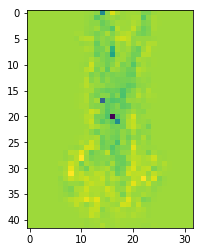

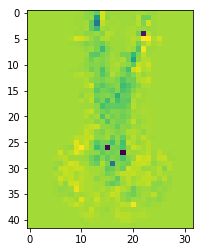

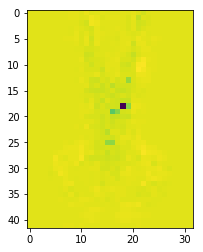

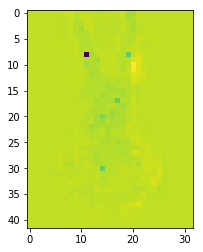

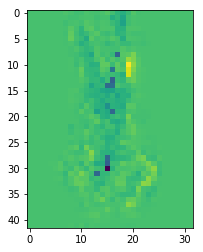

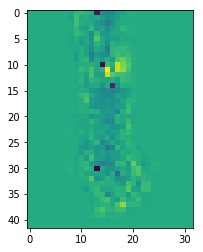

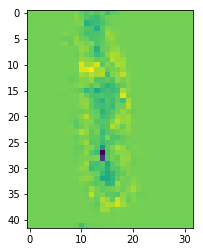

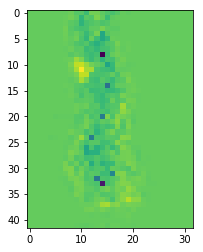

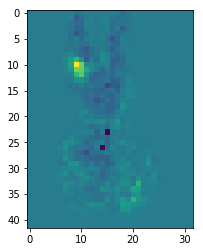

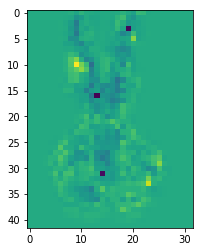

12


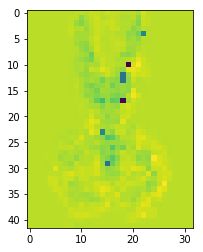

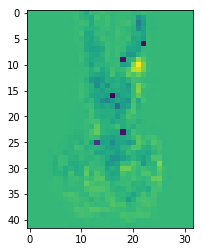

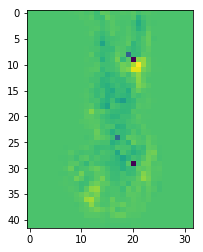

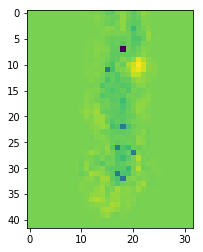

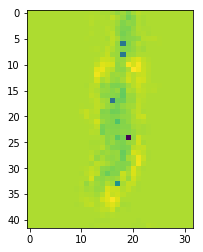

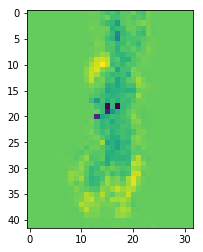

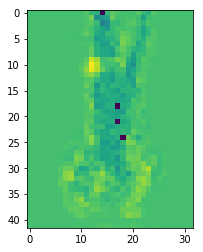

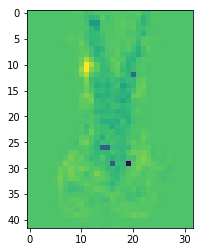

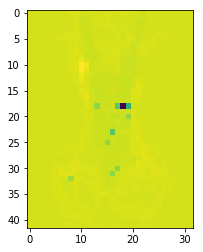

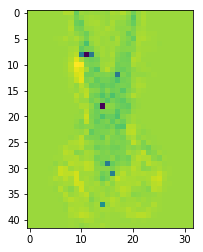

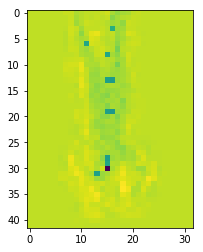

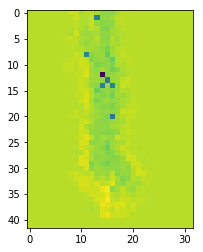

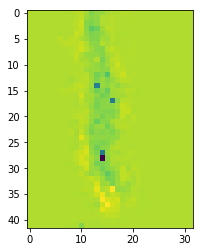

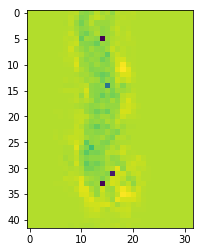

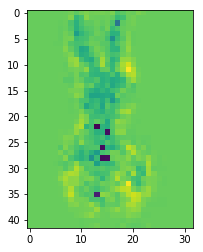

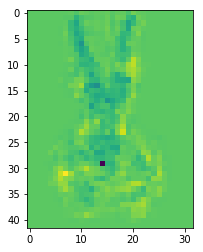

13


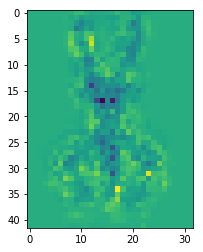

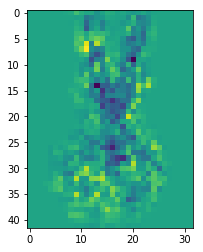

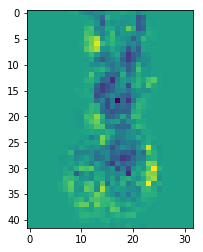

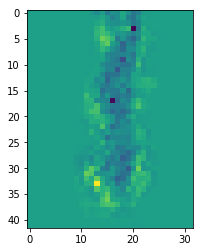

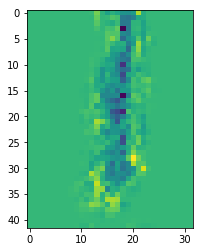

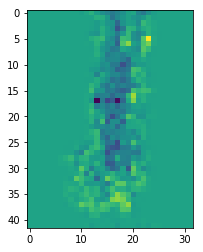

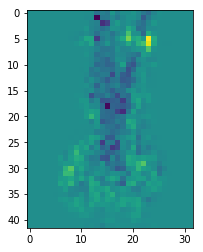

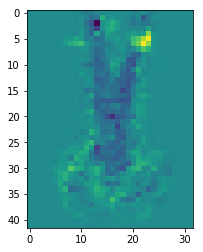

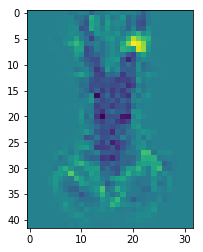

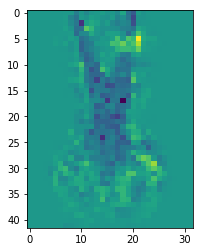

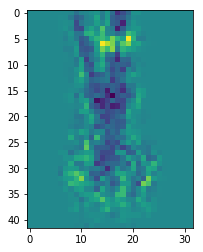

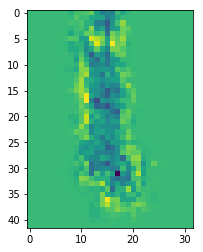

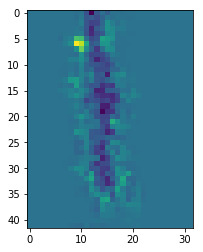

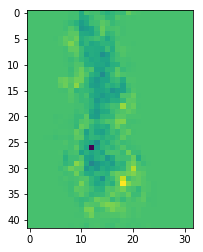

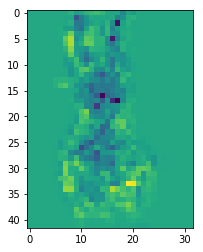

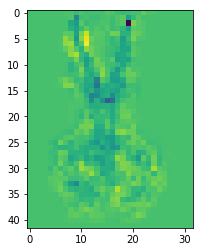

14


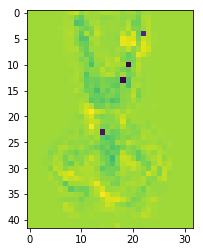

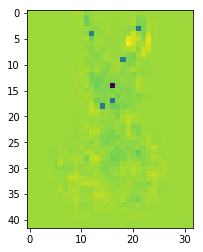

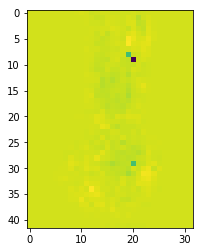

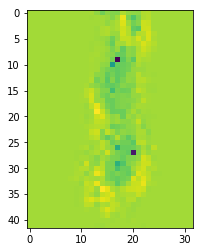

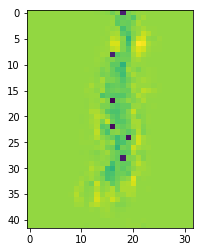

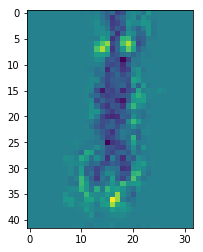

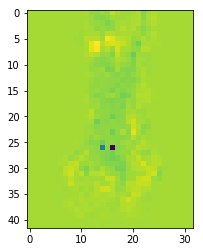

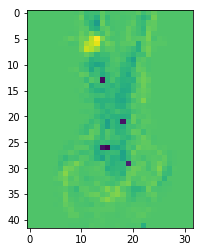

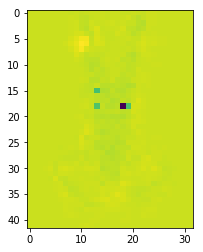

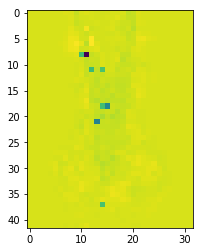

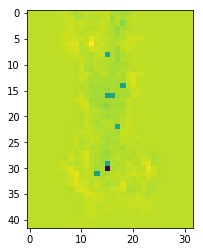

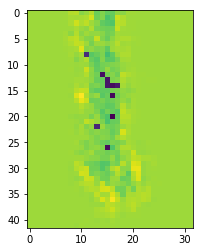

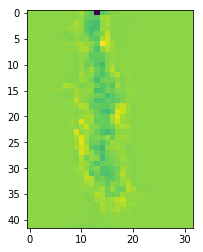

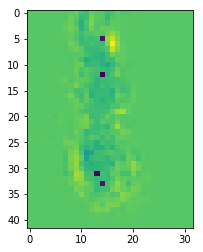

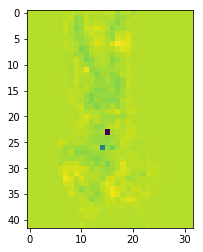

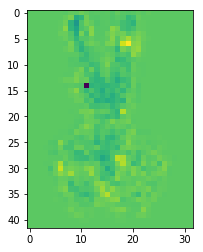

15


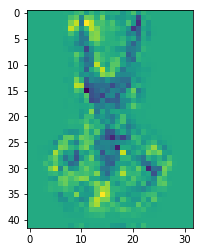

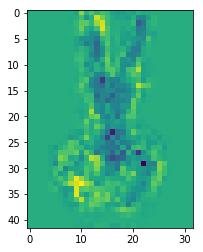

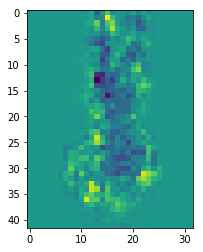

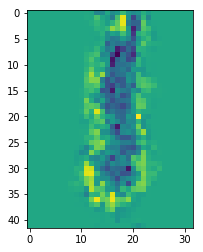

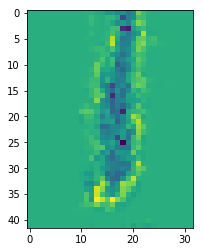

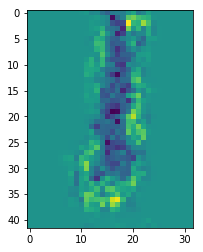

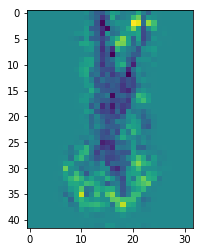

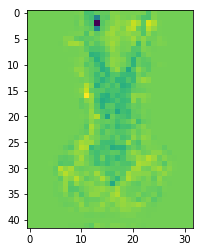

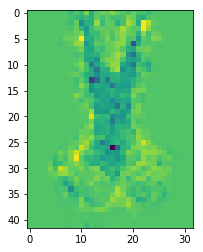

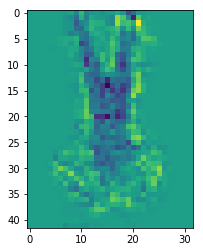

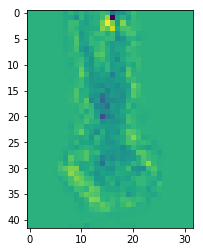

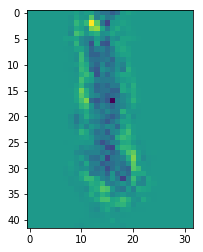

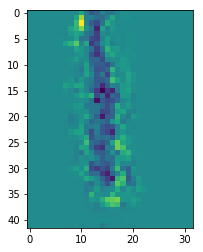

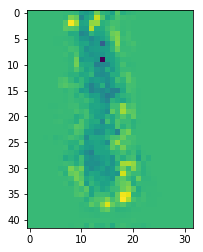

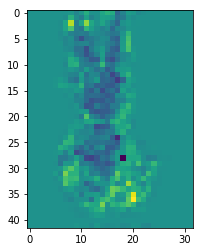

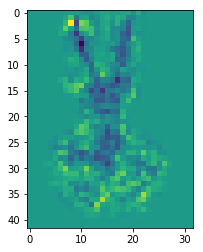

16


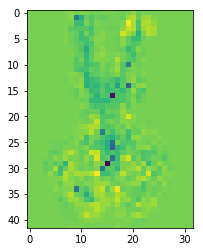

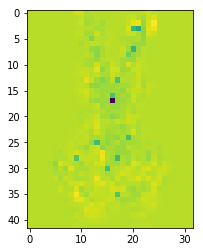

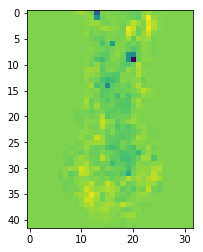

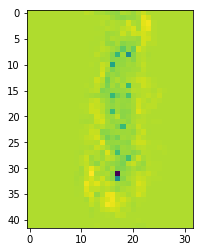

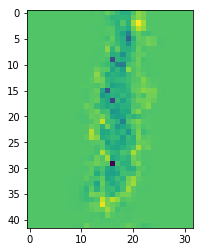

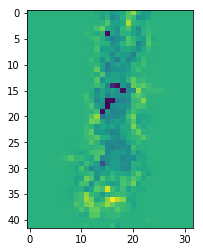

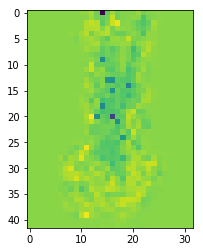

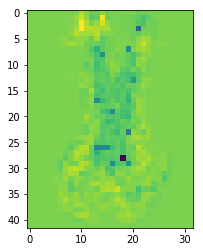

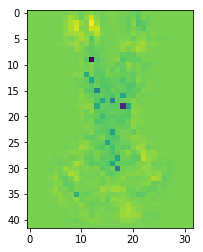

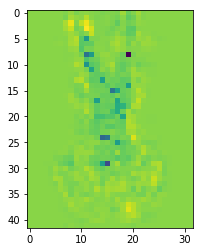

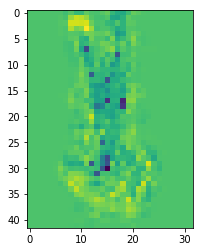

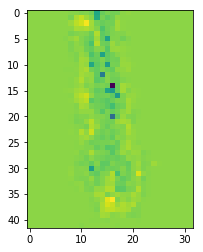

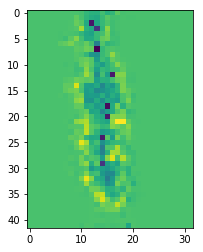

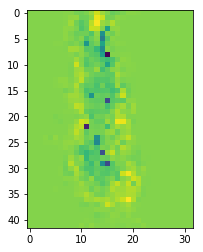

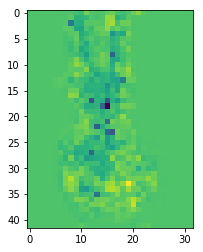

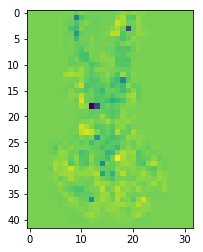

17


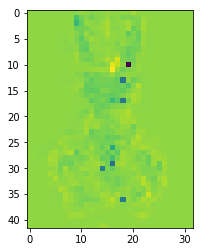

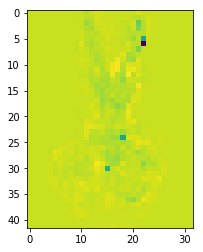

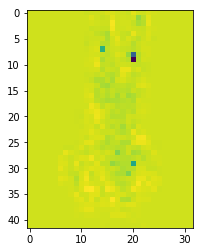

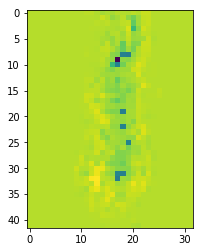

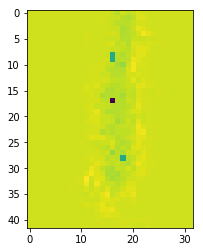

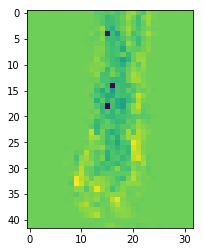

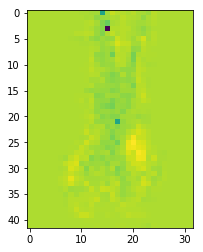

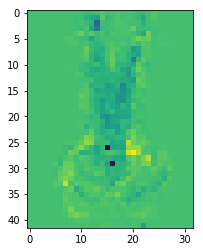

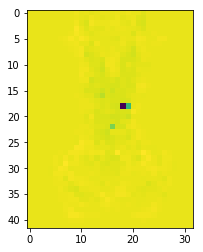

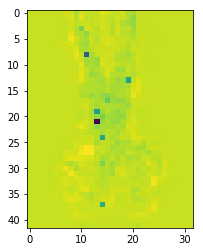

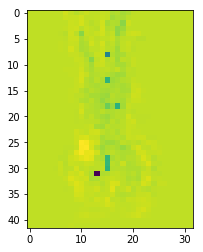

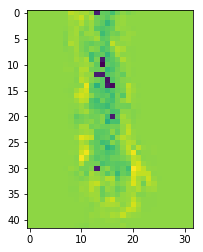

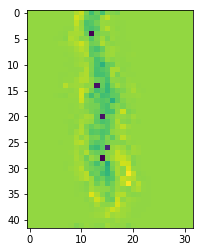

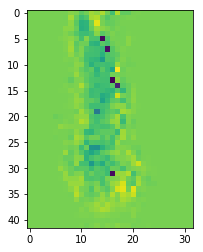

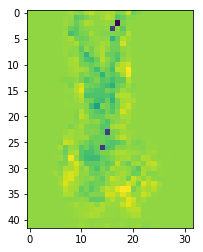

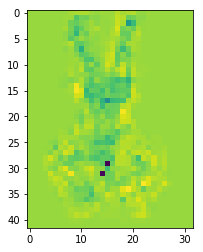

In [40]:
for i in range(1,18):
    classifier = classifiers[i-1]
    zone = classifier.coef_ 
    heatmap = zone.reshape(16,42,32)
    print(i)
    for j in range(0,16):
        plt.imshow(heatmap[j])
        plt.show()

In [19]:
iterator = tsa_utils.ResidueIterator(train_ids, DATA_PATH, pca_model, repeating=False,x=threshold_x,y=threshold_y, pool_size=pool_size, threshold=threshold_threshold)


In [20]:
data = iterator.__next__()

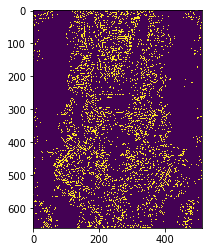

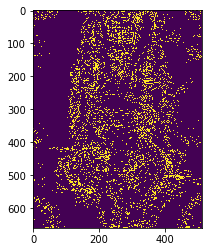

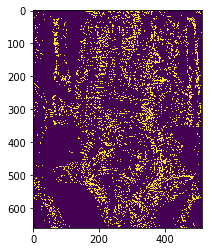

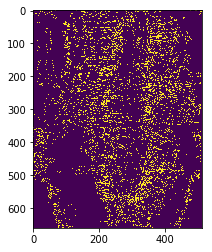

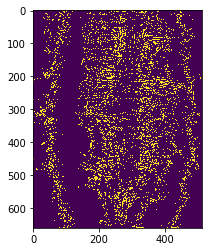

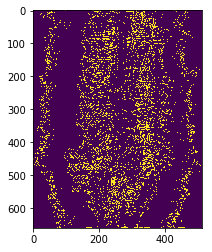

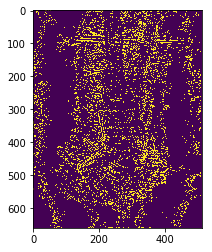

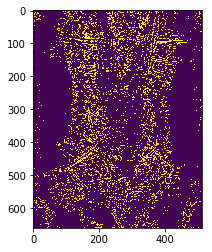

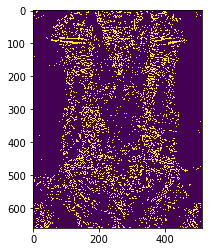

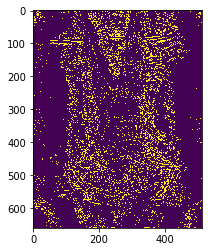

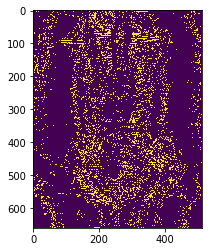

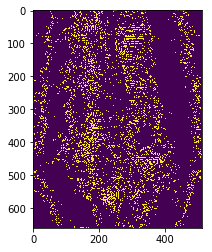

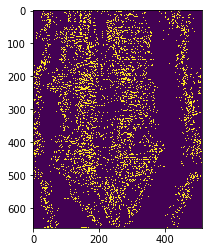

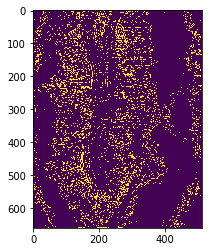

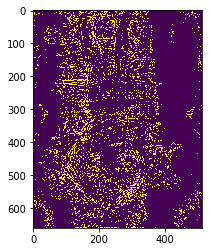

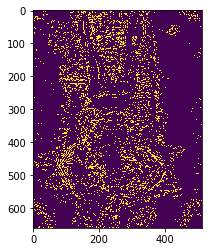

In [21]:
for i in range(0,16):
    plt.imshow(data[i])
    plt.show()